## Demonstrate evaluating the surrogate model and unit transformations
This model was trained by Auralee to predict beam properties at OTR2 using injector
PVs for LCLS.

In [14]:
import json
import torch
import pprint

model_info = json.load(open("configs/model_info.json"))
pv_info = json.load(open("configs/pv_info.json"))

pprint.pprint(model_info)
pprint.pprint(pv_info)


{'loc_in': {'CQ01:b1_gradient': 4,
            'L0A_phase:dtheta0_deg': 7,
            'L0A_scale:voltage': 6,
            'L0B_phase:dtheta0_deg': 9,
            'L0B_scale:voltage': 8,
            'QA01:b1_gradient': 10,
            'QA02:b1_gradient': 11,
            'QE01:b1_gradient': 12,
            'QE02:b1_gradient': 13,
            'QE03:b1_gradient': 14,
            'QE04:b1_gradient': 15,
            'SOL1:solenoid_field_scale': 3,
            'SQ01:b1_gradient': 5,
            'distgen:r_dist:sigma_xy:value': 0,
            'distgen:t_dist:length:value': 1,
            'distgen:total_charge:value': 2},
 'loc_out': {'norm_emit_x': 3,
             'norm_emit_y': 4,
             'sigma_x': 0,
             'sigma_y': 1,
             'sigma_z': 2},
 'model_in_list': ['distgen:r_dist:sigma_xy:value',
                   'distgen:t_dist:length:value',
                   'distgen:total_charge:value',
                   'SOL1:solenoid_field_scale',
                   'CQ01:b1_gradien

In [15]:
from sim_pv_transform import create_transformer

# create a transformer that transforms points in simulation units to PV units
sim_to_pv_transformer = create_transformer(pv_info, model_info["model_in_list"])

# test pvs
ref_point = [4.23867825e-01,
                      3.06083484e+00,
                      2.50000000e+02,
                      2.45806452e-01,
                      7.13917676e-04,
                      3.27285211e-04,
                      5.80000000e+07,
                      -9.53597349e+00,
                      7.00000000e+07,
                        9.85566222e+00,
                          1.85240001e+00,
                      -1.85240001e+00,
                        1.87200002e-01,
                        1.66100000e-01,
                      -2.64090000e+00,
                        2.97999999e+00]
test_sim = torch.tensor(ref_point).double().unsqueeze(0)
pv_vals = sim_to_pv_transformer(test_sim).numpy()

# print PV values for reference point above
pprint.pprint(dict(zip(sim_to_pv_transformer.pv_key_list, pv_vals.flatten(),)))
pv_vals

{'ACCL:IN20:300:L0A_ADES': 58.0,
 'ACCL:IN20:300:L0A_PDES': -9.53597354888916,
 'ACCL:IN20:400:L0B_ADES': 70.0,
 'ACCL:IN20:400:L0B_PDES': 9.85566234588623,
 'Charge': 250.0,
 'IRIS:LR20:130:CONFG_SEL': 1.2716035922406204,
 'Pulse_length': 1.855051445238518,
 'QUAD:IN20:121:BDES': -0.0014992270857504691,
 'QUAD:IN20:122:BDES': -0.0006872989298265359,
 'QUAD:IN20:361:BDES': -2.0005920694658075,
 'QUAD:IN20:371:BDES': 2.0005920694658075,
 'QUAD:IN20:425:BDES': -0.20217599449924495,
 'QUAD:IN20:441:BDES': -0.17938799499030292,
 'QUAD:IN20:511:BDES': 2.852171888123267,
 'QUAD:IN20:525:BDES': -3.2184000203418934,
 'SOLN:IN20:121:BDES': 0.4779693525314514}


array([[ 1.27160359e+00,  1.85505145e+00,  2.50000000e+02,
         4.77969353e-01, -1.49922709e-03, -6.87298930e-04,
         5.80000000e+01, -9.53597355e+00,  7.00000000e+01,
         9.85566235e+00, -2.00059207e+00,  2.00059207e+00,
        -2.02175994e-01, -1.79387995e-01,  2.85217189e+00,
        -3.21840002e+00]])

## Demonstrate NN model

In [19]:
from injector_surrogate import Surrogate, create_nn_transformers

# get transformers for normailzation into NN
nn_input_transformer, nn_output_transformer = create_nn_transformers(
    "configs/normalization.json"
)
test_min = torch.tensor(model_info["train_input_mins"]).unsqueeze(0)
test_max = torch.tensor(model_info["train_input_maxs"]).unsqueeze(0)
print(nn_input_transformer(test_min))
print(nn_input_transformer(test_max))


model = torch.load("torch_model.pt").double()
model.eval()

# define the NN surrogate that contains the NN, the input/output transformers and the
# PV lists for reference
surrogate = Surrogate(
    model,
    model_info["model_in_list"],
    model_info["model_out_list"],
    nn_input_transformer,
    nn_output_transformer
)

print(torch.allclose(surrogate(test_min.double()), torch.ones(1,5).double(), rtol=0.1))


tensor([[ 1.0000e-02,  1.0000e-02,  1.0000e-02,  9.9999e-03,  1.0000e-02,
          1.0000e-02, -7.3761e-09,  1.0000e-02,  0.0000e+00,  1.0000e-02,
          1.0000e-02,  1.0000e-02,  1.0000e-02,  1.0000e-02,  1.0000e-02,
          1.0000e-02]], dtype=torch.float64)
tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e-02,  1.0000e+00,  1.0000e+00,
          1.0000e+00, -7.3761e-09,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00]], dtype=torch.float64)
True


In [26]:
# print bounds of simulation values corresponding to PV's
pprint.pprint(
    dict(zip(sim_to_pv_transformer.pv_key_list, nn_input_transformer.bounds.T.numpy()))
)


{'ACCL:IN20:300:L0A_ADES': array([58000000.00000001, 58000001.01010102]),
 'ACCL:IN20:300:L0A_PDES': array([-25.35215355,   9.99175239]),
 'ACCL:IN20:400:L0B_ADES': array([70000000.      , 70000001.010101]),
 'ACCL:IN20:400:L0B_PDES': array([-25.35324715,   9.99890475]),
 'Charge': array([249.98989899, 251.        ]),
 'IRIS:LR20:130:CONFG_SEL': array([0.20728534, 0.49999961]),
 'Pulse_length': array([ 2.90910613, 11.99856983]),
 'QUAD:IN20:121:BDES': array([-0.01020156,  0.00999252]),
 'QUAD:IN20:122:BDES': array([-0.0102015 ,  0.00999944]),
 'QUAD:IN20:361:BDES': array([0.96975543, 3.99819781]),
 'QUAD:IN20:371:BDES': array([-4.02054462, -1.01051161]),
 'QUAD:IN20:425:BDES': array([0.94010952, 6.9997774 ]),
 'QUAD:IN20:441:BDES': array([-7.08067761,  0.9983521 ]),
 'QUAD:IN20:511:BDES': array([-7.07920347,  0.99930105]),
 'QUAD:IN20:525:BDES': array([0.93944008, 6.99808611]),
 'SOLN:IN20:121:BDES': array([0.19346212, 0.25630309])}
tensor([[ 2.0729e-01,  2.9091e+00,  2.4999e+02,  1.93

In [27]:
import numpy as np
raw_x_data = np.load("data/x_raw_small.npy", allow_pickle=True)
raw_y_data = np.load("data/y_raw_small.npy", allow_pickle=True)

preds = surrogate(torch.tensor(raw_x_data).double(), return_log=True)

print(raw_x_data[0])
print(raw_y_data[0])

[ 3.92211981e-01  5.83776995e+00  2.50000000e+02  2.29980597e-01
  3.92231489e-04 -6.47414040e-03  5.80000000e+07  2.79354164e+00
  7.00000000e+07 -9.86897001e+00  2.14861067e+00 -2.41573625e+00
  2.40720925e+00  7.18128851e-01 -3.74875980e+00  2.33949758e+00]
[0.00016864793055100324 0.0015950831162394174 0.0005424259007070327
 1.3960860485109939e-06 1.1762668344852966e-06]


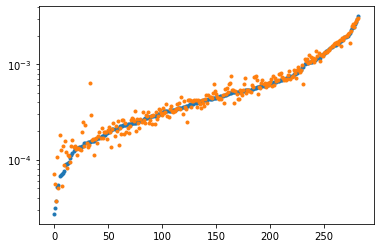

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
sort_idx = np.argsort(raw_y_data[:,0])

# compare model prediction to raw data
ax.semilogy(raw_y_data[:,0][sort_idx],'.')
ax.semilogy(preds[:,0][sort_idx],'.')


In [8]:
# make predictions using pv values
sim_to_pv_transformer.eval()

# create a dummy pv value
test_pv = sim_to_pv_transformer(torch.tensor(raw_x_data[:2]))

# actual process
sim_vals = sim_to_pv_transformer.untransform(test_pv)
preds = surrogate(sim_vals, return_log=True)